In [3]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import csv

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
english_df = pd.read_csv('english_reviews_only.csv', index_col=0, low_memory=False)

In [14]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [15]:
standardized_df = standardize_text(english_df, 'buyerfeedback')

In [16]:
standardized_df.columns

Index(['product_id', 'anonymous', 'buyercountry', 'buyereval', 'buyerfeedback',
       'buyergender', 'buyerheadportrait', 'buyerid', 'buyername', 'evaldate',
       'image', 'logistics', 'skuinfo', 'thumbnail', 'max_freq',
       'initial_trust', 'trust_tag', 'feedback_na', 'image_na',
       'feedbacklength', 'basic_trust', 'basic_trust_tag',
       'reviewer_review_count', 'feedback_lang'],
      dtype='object')

In [17]:
standardized_df.groupby('basic_trust').count()

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,thumbnail,max_freq,initial_trust,trust_tag,feedback_na,image_na,feedbacklength,basic_trust_tag,reviewer_review_count,feedback_lang
basic_trust,,,,,,,,,,,,,,,,,,,,,
0.5,19708,19708,19702,19708,19708,10646,11290,16736,19708,19707,...,8599,3,3,3,19708,19708,19708,19708,16736,19708
1.0,3231,3231,3230,3231,3231,2087,2210,2834,3230,3231,...,3227,6,6,6,3231,3231,3231,3231,2834,3231


In [19]:
#Tokenize the text
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

standardized_df["tokens"] = standardized_df['buyerfeedback'].apply(tokenizer.tokenize)
standardized_df.head()

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,initial_trust,trust_tag,feedback_na,image_na,feedbacklength,basic_trust,basic_trust_tag,reviewer_review_count,feedback_lang,tokens
0,32243608596,False,US,100,"great fabric and quality, fast delivery and co...",NaN,https://ae01.alicdn.com/kf/UTB8vTH0hFPJXKJkSah...,230419691,E***e L.,2018-08-31,...,0.5,No standout reviewer features,False,False,81,0.5,Review has no standout features,2.0,en,"[great, fabric, and, quality, fast, delivery, ..."
4,32243608596,False,US,100,thanks!,F,https://ae01.alicdn.com/kf/UTB8eeCYxqrFXKJk43O...,890393619,E****************r N.,2018-08-18,...,0.5,No standout reviewer features,False,False,7,0.5,Review has no standout features,1.0,en,[thanks]
5,32243608596,False,US,60,not bad for such price,NaN,NaN,1693179945,Y*******d Y.,2018-08-28,...,0.5,No standout reviewer features,False,False,22,0.5,Review has no standout features,1.0,en,"[not, bad, for, such, price]"
7,32243608596,False,US,100,"nice cap, my boyfriend is very happy with it ...",NaN,NaN,1673192723,S*****a W.,2018-08-23,...,1.0,Posts a good number of reviews at a reasonable...,False,True,146,1.0,Trusted Reviewer,1.0,en,"[nice, cap, my, boyfriend, is, very, happy, wi..."
11,32243608596,False,US,20,all stained terrible goods,M,https://gw.alicdn.com/tps/TB1CjX4LXXXXXbSXFXXX...,725446934,S***g C.,2018-08-29,...,1.0,Posts a good number of reviews at a reasonable...,False,False,27,1.0,Trusted Reviewer,1.0,en,"[all, stained, terrible, goods]"


In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in standardized_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in standardized_df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

394264 words total, with a vocabulary size of 11499
Max sentence length is 194


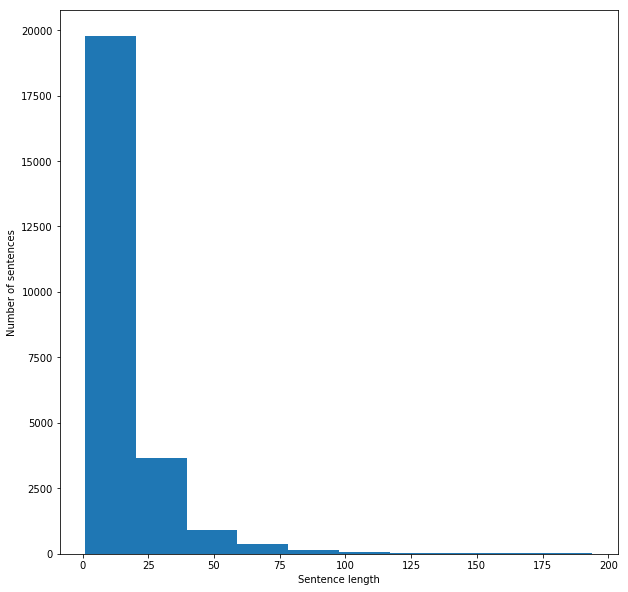

In [23]:
#most reviews are short
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [34]:
standardized_df['trainable_trust'] = standardized_df['basic_trust'] ==1
standardized_df.head()

,product_id,anonymous,buyercountry,buyereval,buyerfeedback,buyergender,buyerheadportrait,buyerid,buyername,evaldate,...,trust_tag,feedback_na,image_na,feedbacklength,basic_trust,basic_trust_tag,reviewer_review_count,feedback_lang,tokens,trainable_trust
0,32243608596,False,US,100,"great fabric and quality, fast delivery and co...",NaN,https://ae01.alicdn.com/kf/UTB8vTH0hFPJXKJkSah...,230419691,E***e L.,2018-08-31,...,No standout reviewer features,False,False,81,0.5,Review has no standout features,2.0,en,"[great, fabric, and, quality, fast, delivery, ...",False
4,32243608596,False,US,100,thanks!,F,https://ae01.alicdn.com/kf/UTB8eeCYxqrFXKJk43O...,890393619,E****************r N.,2018-08-18,...,No standout reviewer features,False,False,7,0.5,Review has no standout features,1.0,en,[thanks],False
5,32243608596,False,US,60,not bad for such price,NaN,NaN,1693179945,Y*******d Y.,2018-08-28,...,No standout reviewer features,False,False,22,0.5,Review has no standout features,1.0,en,"[not, bad, for, such, price]",False
7,32243608596,False,US,100,"nice cap, my boyfriend is very happy with it ...",NaN,NaN,1673192723,S*****a W.,2018-08-23,...,Posts a good number of reviews at a reasonable...,False,True,146,1.0,Trusted Reviewer,1.0,en,"[nice, cap, my, boyfriend, is, very, happy, wi...",True
11,32243608596,False,US,20,all stained terrible goods,M,https://gw.alicdn.com/tps/TB1CjX4LXXXXXbSXFXXX...,725446934,S***g C.,2018-08-29,...,Posts a good number of reviews at a reasonable...,False,False,27,1.0,Trusted Reviewer,1.0,en,"[all, stained, terrible, goods]",True


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = standardized_df["buyerfeedback"].tolist()
list_labels = standardized_df["trainable_trust"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

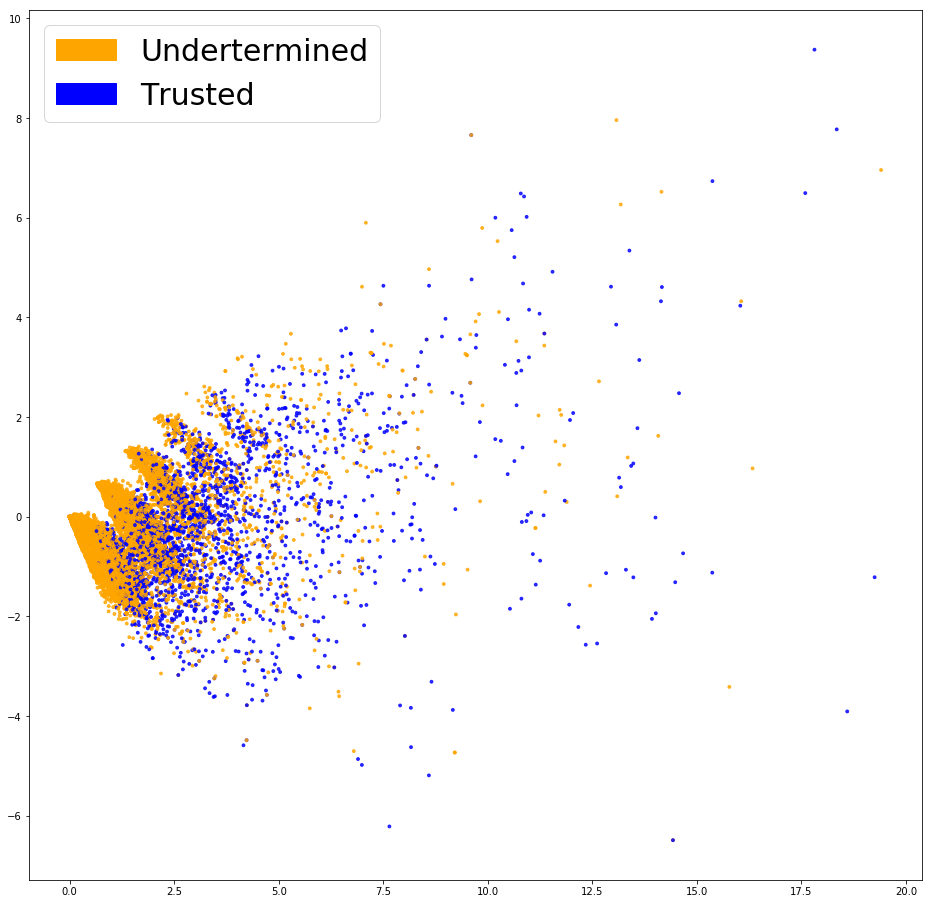

In [36]:
from  sklearn.decomposition  import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Undertermined')
            green_patch = mpatches.Patch(color='blue', label='Trusted')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

%matplotlib inline
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [30]:
#The reviews actually look moderately separable based on this

In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [49]:
import pickle
filename = 'pickled_logistic_regression_bag_of_words.sav'
pickle.dump(clf, open(filename, 'wb'))

In [54]:
standardized_df['predicted_trust'] = clf.predict(count_vectorizer.transform(list_corpus))

In [56]:
standardized_df.head()
standardized_df.to_csv('english_reviews_predicted_trust.csv')

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.880, precision = 0.881, recall = 0.880, f1 = 0.881


In [39]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [41]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

KeyError: 1

In [42]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

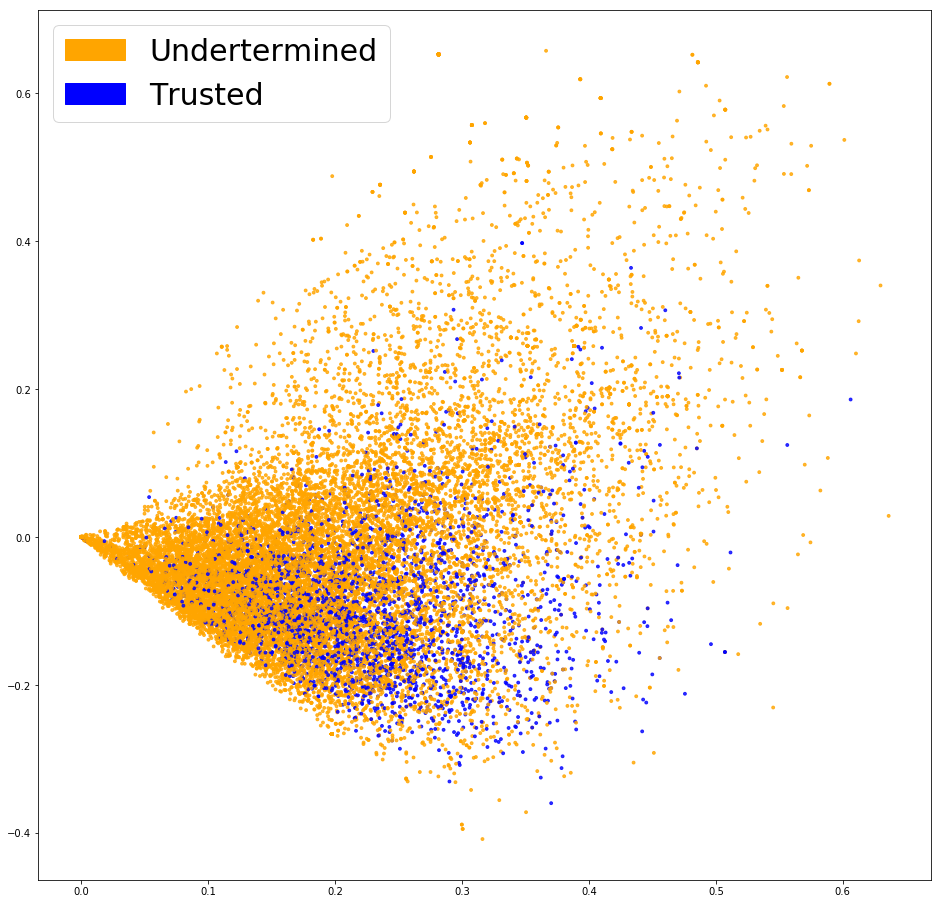

In [43]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [44]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [45]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.866, precision = 0.879, recall = 0.866, f1 = 0.871


In [46]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

ModuleNotFoundError: No module named 'gensim'